## File Upload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import ipywidgets as widgets
from IPython.display import display

# File upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def load_image(uploader):
    if uploader.value:
        upload_obj = uploader.value[0]
        content = upload_obj['content']  # or upload_obj.content if attribute access is supported
        img = io.imread(content, plugin='imageio')
        return img
    else:
        return None

img = load_image(uploader)


FileUpload(value=(), accept='image/*', description='Upload')

## 1. Gaussian Noise + Otsu’s Thresholding


C:\Users\hirun\AppData\Local\Temp\ipykernel_22364\231156256.py:15: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  img = io.imread(content, plugin='imageio')


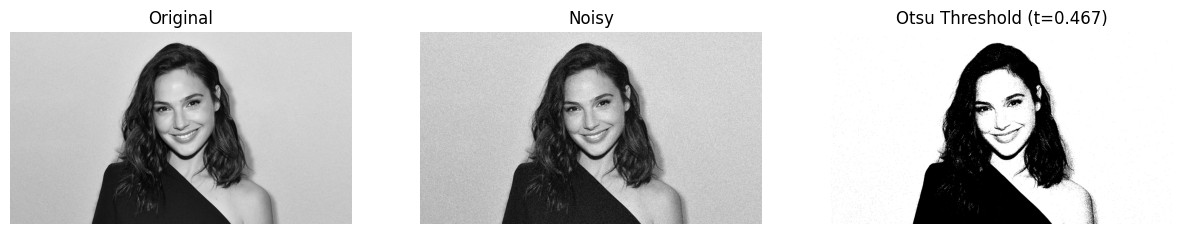

In [13]:
from skimage.filters import threshold_otsu
from skimage.util import random_noise

# Load image
img = load_image(uploader)
if img is None:
    raise ValueError("Please upload an image before running this cell.")

# Convert to grayscale if needed
if img.ndim == 3:
    img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
else:
    img_gray = img

# Normalize to [0,1]
img_norm = img_gray / img_gray.max()

# Add Gaussian noise
noisy = random_noise(img_norm, mode='gaussian', var=0.01)

# Compute Otsu threshold
thresh = threshold_otsu(noisy)
binary = noisy > thresh

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_norm, cmap='gray'); axes[0].set_title('Original')
axes[1].imshow(noisy, cmap='gray'); axes[1].set_title('Noisy')
axes[2].imshow(binary, cmap='gray'); axes[2].set_title(f'Otsu Threshold (t={thresh:.3f})')
for ax in axes:
    ax.axis('off')
plt.show()


## 2. Region-Growing Segmentation

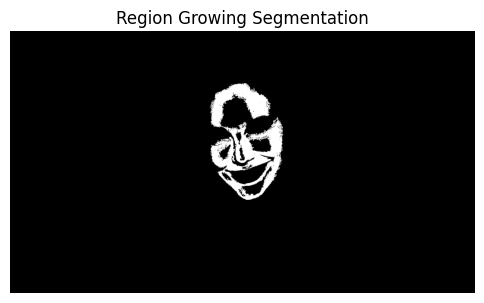

In [15]:
from collections import deque

def region_growing(img, seeds, thresh=0.05):
    # img: normalized grayscale image [0,1]
    h, w = img.shape
    seg = np.zeros((h, w), dtype=bool)
    visited = np.zeros_like(seg)
    dq = deque(seeds)
    seed_vals = [img[y, x] for y, x in seeds]
    mean_val = np.mean(seed_vals)

    while dq:
        y, x = dq.popleft()
        if visited[y, x]:
            continue
        visited[y, x] = True
        if abs(img[y, x] - mean_val) <= thresh:
            seg[y, x] = True
            # Add neighbors
            for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
                ny, nx = y+dy, x+dx
                if 0 <= ny < h and 0 <= nx < w and not visited[ny, nx]:
                    dq.append((ny, nx))

    return seg

# Example usage:
# Ensure grayscale & normalized
img = img_norm
# Define seed points (list of (row, col))
seeds = [(int(img.shape[0]/2), int(img.shape[1]/2))]  # adjust as needed
segmentation = region_growing(img, seeds, thresh=0.1)

# Display region growing result
plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap='gray')
plt.title('Region Growing Segmentation')
plt.axis('off')
plt.show()
